In [3]:
%matplotlib inline 

import h5py
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')

In [38]:
read_counts = {
    'rep_1': 27.148602,
    'rep_2': 23.52997,
    'rep_1_input': 29.02927,
    'rep_2_input': 30.379016,
    'groseq': 11.806518
}

In [15]:
metadata_plotting = {
    0: (['ENCFF867UVJ', 'ENCFF837QHG'], 'H3K36me3', 'blue'),
    1: (['ENCFF286DPW', 'ENCFF185UFB'], 'H3K4me3', 'red'), 
    2: (['ENCFF380OGG', 'ENCFF638EFN'], 'H3K9me3', '#444444'), 
}

In [16]:
combined = {}

with h5py.File('matrix_data/ho_cd_ChIPs.hdf5', 'r') as f:
    for key in f:
        combined[key] = np.array(f[key])

In [17]:
centers = {}

with h5py.File('matrix_data/gene_centers_ChIPs.hdf5', 'r') as f:
    for key in f:
        centers[key] = np.array(f[key])

In [26]:
gc_content = {}
with h5py.File('matrix_data/gc_content.hdf5', 'r') as f:
    for key in f:
        gc_content[key] = np.array(f[key])

In [40]:
total_centers = {}
with h5py.File('matrix_data/DRIP_Seq.hdf5', 'r') as f:
    for key in f['mNET_Seq_around_gene_centers']:
        total_centers[key] = np.array(f['mNET_Seq_around_gene_centers'][key])

total_mnet = {}
with h5py.File('matrix_data/DRIP_Seq.hdf5', 'r') as f:
    for key in f['mNET_Seq_around_origins']:
        total_mnet[key] = np.array(f['mNET_Seq_around_origins'][key])

In [45]:
total_mnet.keys()

dict_keys(['rep_2', 'si_Luc', 'rep_1'])

In [43]:
total_groseq = {}
with h5py.File('matrix_data/DRIP_Seq.hdf5', 'r') as f:
    plus = np.concatenate([
            np.array(f['GRO_Seq_around_origins']['CD_HO_plus'])[:, ::-1],
            np.array(f['GRO_Seq_around_origins']['HO_CD_plus'])
        ])/read_counts['groseq']
    minus = np.concatenate([
            np.array(f['GRO_Seq_around_origins']['CD_HO_minus'])[:, ::-1],
            np.array(f['GRO_Seq_around_origins']['HO_CD_minus'])
        ])/read_counts['groseq']

    total_groseq['ho_cd'] = (plus + minus)
    # Script for generating these files already inverted coordinates
    total_groseq['centers'] = (np.array(f['GRO_Seq_around_gene_centers']['sense']) + 
                          np.array(f['GRO_Seq_around_gene_centers']['antisense']))/read_counts['groseq']

In [19]:
single_genes_body = np.load('matrix_data/index_of_single_genes.npy')

In [22]:
histone_data = pd.read_csv('histone_data.tsv', sep='\t')
dnase_data = pd.read_csv('dnase_data.tsv', sep='\t')


In [59]:
used = set(['ENCFF867UVJ', 'ENCFF837QHG', 'ENCFF286DPW', 'ENCFF185UFB','ENCFF380OGG', 'ENCFF638EFN'])

In [60]:
histone_data[histone_data.file.isin(used)]

,file,replicate,target,read_count
0,ENCFF867UVJ,1,H3K36me3,572188506
1,ENCFF837QHG,2,H3K36me3,636980564
8,ENCFF380OGG,2,H3K9me3,387910254
9,ENCFF638EFN,1,H3K9me3,1385063854
18,ENCFF286DPW,1,H3K4me3,2475920627
19,ENCFF185UFB,2,H3K4me3,1294129271


In [61]:
dna_used = set(['ENCFF066BXL','ENCFF688AHB' ])

In [62]:
dnase_data[dnase_data.file.isin(dna_used)]

,file,replicate,target,read_count
4,ENCFF066BXL,1,DNase-seq,1385457198
5,ENCFF688AHB,2,DNase-seq,1439508992


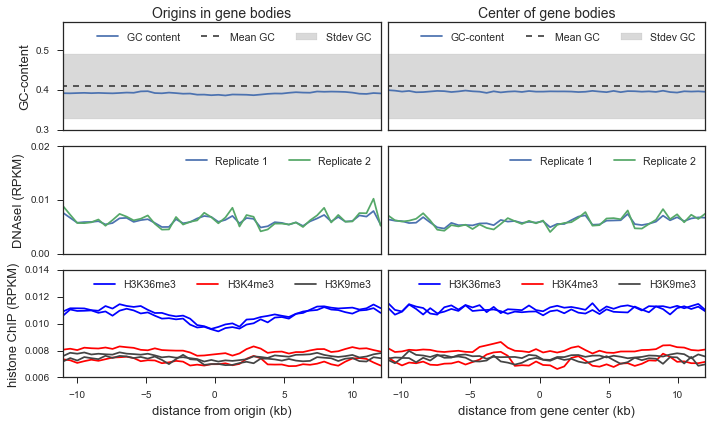

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex= True)

legend_size = 10.5
axis_size = 13
title_size = 16


for i, metadata in metadata_plotting.items():
    for acession in metadata[0]:
        ax[2, 0].plot(np.linspace(-12,12,48), 
                      (2*combined[acession][single_genes_body, 0:48].mean(axis=0)/
                      (histone_data[histone_data.file == acession].read_count.iloc[0]/1e6)),
                      color=metadata[2], label=metadata[1]
                     )
        ax[2, 1].plot(np.linspace(-12,12,48), 
                      (2*centers[acession].mean(axis=0)/
                       (histone_data[histone_data.file == acession].read_count.iloc[0]/1e6)),
                       color=metadata[2], label=metadata[1]                
                     )
handles, labels = ax[2, 0].get_legend_handles_labels()
ax[2, 0].legend(labels=labels[::2], handles=handles[::2], ncol=3, fontsize=legend_size)
ax[2, 1].legend(labels=labels[::2], handles=handles[::2], ncol=3, fontsize=legend_size)

for acession in ['ENCFF066BXL', 'ENCFF688AHB']:
    ax[1, 0].plot(np.linspace(-12,12,48), 
                  (2*combined[acession][single_genes_body, 0:48].mean(axis=0)/
                  (dnase_data[dnase_data.file == acession].read_count.iloc[0]/1e6)))
    ax[1, 1].plot(np.linspace(-12,12,48), 
                  (2*centers[acession][:, 0:48].mean(axis=0)/
                  (dnase_data[dnase_data.file == acession].read_count.iloc[0]/1e6)))
    ax[1, 0].set_xlim(-12,12)
    ax[1, 1].set_xlim(-12,12)
    ax[1, 0].set_ylim(0, 0.05)
    ax[1, 1].set_ylim(0, 0.05)

ax[2, 0].set_xlabel('distance from origin (kb)', fontsize=axis_size)
ax[2, 1].set_xlabel('distance from gene center (kb)', fontsize=axis_size)

ax[2, 0].set_ylabel('histone ChIP (RPKM)', fontsize=axis_size)
ax[1, 0].set_ylabel('DNAseI (RPKM)', fontsize=axis_size)
ax[0, 0].set_yticks(np.linspace(0, 0.05, 6))
ax[0, 0].set_yticks(np.linspace(0, 0.05, 6))
ax[1, 0].set_yticks(np.linspace(0, 0.05, 6))
ax[1, 0].legend(['Replicate 1', 'Replicate 2'], loc='best', ncol=2, fontsize=legend_size)
ax[1, 1].legend(['Replicate 1', 'Replicate 2'], loc='best', ncol=2, fontsize=legend_size)

ax[0,0].plot(np.linspace(-12,12,48), gc_content['ho_cd'][single_genes_body, :].mean(axis=0), label='GC content')
ax[0,1].plot(np.linspace(-12,12,48), gc_content['gene_centers'].mean(axis=0), label='GC-content')

for i in range(2):
    ax[0, i].plot([-12,12], [0.4094, 0.4094], linestyle='dashed', color='#444444', label='Mean GC')
    ax[0, i].fill_between([-12,12], [0.3275,0.3275], [0.4914,0.4914], color='#444444', alpha=0.2, label='Stdev GC')
    ax[0, i].set_xlim(-11, 12)
    ax[0, 0].set_ylabel('GC-content', fontsize=axis_size)
    ax[0, 0].yaxis.set_ticks_position('left')
    ax[2, i].xaxis.set_ticks_position('bottom')
    ax[0, i].legend(ncol=3, fontsize=legend_size)

ax[0, 0].yaxis.set_ticks_position('left')
ax[1, 0].yaxis.set_ticks_position('left')
ax[2, 0].yaxis.set_ticks_position('left')

for i in range(3):
    for j in range(2):
            if not j == 0:
                ax[i,j].yaxis.set_visible(False)
            if not i == 2:
                ax[i,j].xaxis.set_visible(False)
            if i == 2:
                ax[i, j].set_ylim(0.006, 0.014)
                ax[i, j].set_yticks(np.arange(0.006, 0.016, 0.002))
            elif i == 1:
                ax[i, j].set_ylim(0.00, 0.02)
            elif i == 0:
                ax[i, j].set_ylim(0.30, 0.57)
                ax[i, j].set_yticks(np.arange(0.30, 0.57, 0.1))
                
ax[0, 1].set_title('Center of gene bodies', fontsize=14)
ax[0, 0].set_title('Origins in gene bodies', fontsize=14)

plt.tight_layout(w_pad=0.7, h_pad=-0.1)

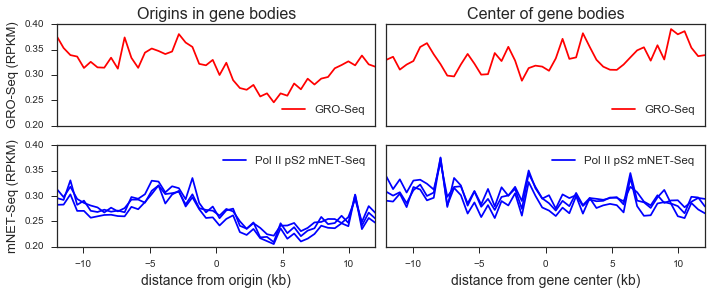

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,4.2), sharey=True, sharex=True)

plt.style.use('seaborn-ticks')

legend_size = 11.5
axis_size = 13
title_size = 16

ax[0, 0].plot(np.linspace(-12,12,48), total_groseq['ho_cd'][single_genes_body, :].mean(axis=0) * 2, color='#FF0000')
ax[0, 0].set_title('Origins in gene bodies', fontsize=title_size)
ax[0, 0].set_ylabel('GRO-Seq (RPKM)', fontsize=axis_size)
#ax[1].plot([0, 0],[1.4, 2.4], '#444444', linestyle='dashed')
ax[0, 0].legend(['GRO-Seq'], fontsize=legend_size, loc='lower right')
ax[0, 0].set_ylim(0.2,0.45)

# Plot RNAP2 ChIP exp2
ax[1, 0].plot(np.linspace(-12,12,48), total_mnet['rep_1'][single_genes_body, :].mean(axis=0)* 2, 'b')
ax[1, 0].plot(np.linspace(-12,12,48), total_mnet['rep_2'][single_genes_body, :].mean(axis=0)* 2, 'b')
ax[1, 0].plot(np.linspace(-12,12,48), total_mnet['si_Luc'][single_genes_body, :].mean(axis=0)* 2, 'b')
ax[1, 0].legend(['Pol II pS2 mNET-Seq'], fontsize=legend_size)
ax[1, 0].set_ylabel('mNET-Seq (RPKM)', fontsize=axis_size)
#ax[2].plot([0, 0],[0.15, 0.55], '#444444', linestyle='dashed')
ax[1, 0].set_ylim(0.20,0.40)

ax[0, 1].plot(np.linspace(-12,12,48), total_groseq['centers'][:, :].mean(axis=0) * 2, color='#FF0000')
ax[0, 1].set_title('Center of gene bodies', fontsize=title_size)
#ax[1].plot([0, 1],[1.4, 2.4], '#444444', linestyle='dashed')
ax[0, 1].legend(['GRO-Seq'], loc='lower right', fontsize=legend_size)
ax[0, 1].set_ylim(0.2,0.45)

# Plot RNAP2 ChIP exp2
ax[1, 1].plot(np.linspace(-12,12,48), total_centers['rep_1'].mean(axis=0)* 2, 'b')
ax[1, 1].plot(np.linspace(-12,12,48), total_centers['rep_2'].mean(axis=0)* 2, 'b')
ax[1, 1].plot(np.linspace(-12,12,48), total_centers['si_Luc'].mean(axis=0)* 2, 'b')
ax[1, 1].legend(['Pol II pS2 mNET-Seq'], fontsize=legend_size)
#ax[2].plot([0, 1],[0.15, 0.55], '#444444', linestyle='dashed')
ax[1, 1].set_ylim(0.20,0.40)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim(-12,12)
        ax[i, j].yaxis.set_ticks_position('left')
        ax[i, j].xaxis.set_ticks_position('bottom')
        if j == 1:
            ax[i, j].yaxis.set_visible(False)
    ax[0, i].xaxis.set_visible(False)
    
ax[1, 0].set_xlabel('distance from origin (kb)', fontsize=14)
ax[1, 1].set_xlabel('distance from gene center (kb)', fontsize=14)
            
fig.tight_layout()

# Locations of genes in gene body

In [5]:
# Load bed files

bed_files = {}
bed_cols = ['chr', 'start', 'end', 'domain']
bed_files['cd_cd'] = pd.read_csv('bed_files/CD_CD.bed', sep='\t', names=bed_cols)
bed_files['ho_ho'] = pd.read_csv('bed_files/HO_HO.bed', sep='\t', names=bed_cols)
bed_files['ho_cd'] = pd.concat([pd.read_csv('bed_files/CD_HO.bed', sep='\t', names=bed_cols),
                                pd.read_csv('bed_files/HO_CD.bed', sep='\t', names=bed_cols)
                               ], axis=0)

In [6]:
# Load data
intersect_cols = ('chr', 'start', 'end', 'domain', 'chr_gene', 'start_gene', 'end_gene', 'count', 'ucsc_name', 'strand', 'overlap')
gene_intersections = {}
gene_intersections['ho_cd'] = pd.concat([
        pd.read_csv('gene_overlaps/HO_CD.bed', sep='\t', names=intersect_cols),
        pd.read_csv('gene_overlaps/CD_HO.bed', sep='\t', names=intersect_cols)
    ])

temp = gene_intersections['ho_cd'].domain.value_counts()

# Pick out regions that overlap a gene over the entire window
single_gene_regions = (set(temp[temp == 1].index) & 
                      set(gene_intersections['ho_cd'][gene_intersections['ho_cd'].overlap == 24001].domain))
single_genes = np.array(bed_files['ho_cd'].domain.isin(single_gene_regions))  

# Get the true TSS and TES sites for the genes, taking into account the strandedness
genes_ho_cd = gene_intersections['ho_cd'].copy()
genes_ho_cd['tx_start'] = genes_ho_cd['start_gene']
genes_ho_cd.loc[genes_ho_cd.strand == '-', 'tx_start'] = genes_ho_cd.loc[genes_ho_cd.strand == '-', 'end_gene']
genes_ho_cd['tx_end'] = genes_ho_cd['end_gene']
genes_ho_cd.loc[genes_ho_cd.strand == '-', 'tx_end'] = genes_ho_cd.loc[genes_ho_cd.strand == '-', 'start_gene']

# Find the minimum distance within each region to any gene's promoter and terminator 
genes_ho_cd['min_distance_to_promoter'] = np.abs(genes_ho_cd[['start', 'end']].as_matrix() - genes_ho_cd.tx_start.as_matrix().reshape(7148,1)).min(axis=1)
genes_ho_cd['min_distance_to_terminator'] = np.abs(genes_ho_cd[['start', 'end']].as_matrix() - genes_ho_cd.tx_end.as_matrix().reshape(7148,1)).min(axis=1)

# Select out only those regions at least 5000 bp from a gene boundary 
PROMOTER_CUTOFF = 5000 #Base pairs
TERMINATOR_CUTOFF = 5000 #Base pairs

single_gene_regions_no_promoter = (
                                   set(temp[temp == 1].index) & 
                                   set(gene_intersections['ho_cd'][gene_intersections['ho_cd'].overlap == 24001].domain) &
                                   set(genes_ho_cd[genes_ho_cd.min_distance_to_promoter.abs() > PROMOTER_CUTOFF].domain) &
                                   set(genes_ho_cd[genes_ho_cd.min_distance_to_terminator.abs() > TERMINATOR_CUTOFF].domain)
                                  )
single_genes_body = np.array(bed_files['ho_cd'].domain.isin(single_gene_regions_no_promoter)) 

single_gene_genes = set(genes_ho_cd[genes_ho_cd.domain.isin(single_gene_regions_no_promoter)].ucsc_name)

In [7]:
genes_ho_cd['position'] = genes_ho_cd['start'] + 11999
genes_ho_cd['percent_location'] = (genes_ho_cd.tx_start - genes_ho_cd.position)/(genes_ho_cd.tx_start - genes_ho_cd.tx_end)
genes_ho_cd['percent_location_end'] = (genes_ho_cd.tx_start - (genes_ho_cd.position + 12000))/(genes_ho_cd.tx_start - genes_ho_cd.tx_end)
genes_ho_cd['percent_location_start'] = (genes_ho_cd.tx_start - (genes_ho_cd.position - 12000))/(genes_ho_cd.tx_start - genes_ho_cd.tx_end)

In [14]:
single_regions_body = genes_ho_cd[genes_ho_cd.domain.isin(single_gene_regions_no_promoter)]

indicies = np.zeros(100)
for i, row in single_regions_body.iterrows():
    indicies[int(row.percent_location_start * 100//1):int(row.percent_location_end * 100//1)] += 1

In [9]:
gene_locations = single_regions_body.copy()

gene_locations['length'] = (gene_locations.end_gene - gene_locations.start_gene)
gene_locations['mean_position'] = (gene_locations.end_gene + gene_locations.start_gene) //2

gene_locations.percent_location_end = ((gene_locations.mean_position + 12000) - gene_locations.start_gene)/gene_locations.length
gene_locations.percent_location_start = ((gene_locations.mean_position - 12000) - gene_locations.start_gene)/gene_locations.length

gene_locations = gene_locations.drop_duplicates('ucsc_name')

gene_indicies = np.zeros(100)
for i, row in gene_locations.iterrows():
    gene_indicies[int(row.percent_location_start * 100//1):int(row.percent_location_end * 100//1)] += 1

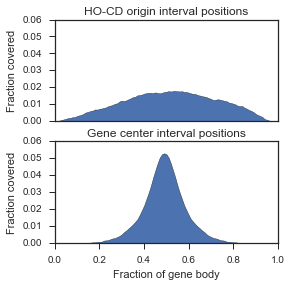

In [15]:
x = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(nrows=2, sharey=True, sharex=True, figsize=(4,4))

ax[0].fill_between(x, np.zeros_like(x), indicies/indicies.sum())
ax[1].fill_between(x, np.zeros_like(x), gene_indicies/gene_indicies.sum())

ax[0].set_title('HO-CD origin interval positions')
ax[1].set_title('Gene center interval positions')

ax[1].set_xlabel('Fraction of gene body')
ax[0].set_ylabel('Fraction covered')
ax[1].set_ylabel('Fraction covered')


ax[0].xaxis.tick_bottom()
ax[0].yaxis.tick_left()
ax[1].xaxis.tick_bottom()
ax[1].yaxis.tick_left()
ax[0].xaxis.set_visible(False)
